# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [28]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [29]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [30]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\Bjorn\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [31]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [32]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

In [7]:
# Laster inn datasettet
df = pd.read_csv("./datasett2.csv")

# Konverterer kategoriske variabler til heltall
kolonner_obj = df.select_dtypes(include=['object']).columns

for i in kolonner_obj:
    unique_values = list(df[i].unique())
    df[df.columns.get_loc(i)] = df[i].apply(lambda x: unique_values.index(x))

# Deler datasettet inn i egenskaper (X) og mål (y)
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

# Deler inn i trenings- og testsett
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

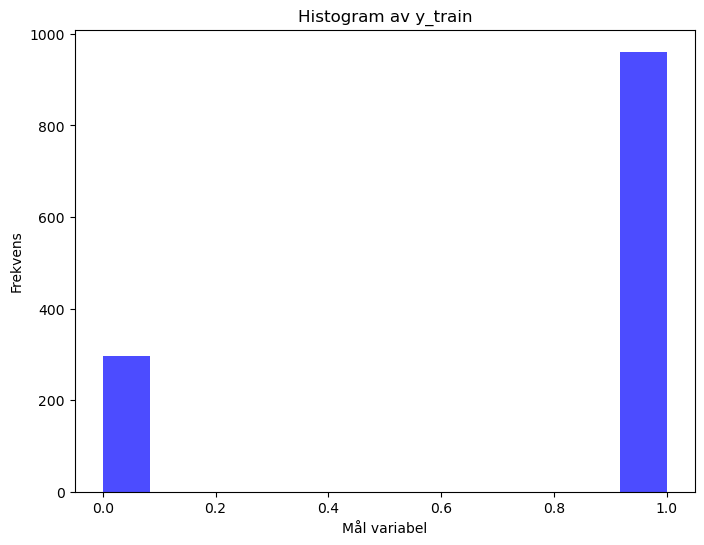

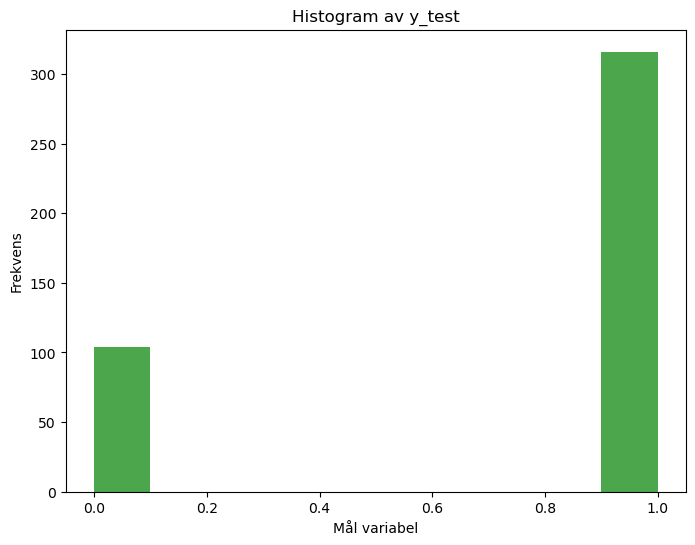

In [8]:
#TODO: visualiser y_train og y_test i et histogram

import matplotlib.pyplot as plt

# Visualisere y_train i et histogram
plt.figure(figsize=(8, 6))
plt.hist(y_train, bins='auto', color='blue', alpha=0.7)
plt.title('Histogram av y_train')
plt.xlabel('Mål variabel')
plt.ylabel('Frekvens')
plt.show()

# Visualisere y_test i et histogram
plt.figure(figsize=(8, 6))
plt.hist(y_test, bins='auto', color='green', alpha=0.7)
plt.title('Histogram av y_test')
plt.xlabel('Mål variabel')
plt.ylabel('Frekvens')
plt.show()


**Svar:**

*< ditt tekstsvar her >*

Det ser ut som målvariabelen har et begrenset sett med diskrete verdier, noe som forårsaker hull mellom stolpene. Denne typen fordeling antyder at vi har et klassifiseringsproblem, ikke et regresjonsproblem.

I et regresjonsproblem vil målvariabelen typisk ha en kontinuerlig og jevn fordeling, mens målvariabelen i et klassifiseringsproblem består av forskjellige klasser eller kategorier, noe som resulterer i et histogram med atskilte søyler.

Det er sannsynlig at målvariabelen representerer forskjellige klasser eller kategorier, noe som gjør det til et klassifiseringsproblem.

<span style='color:red '> Du er inne på det her. Target er en binær variabel (0 eller 1) og derfor er det er klassifiseringsproblem.  </span>

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


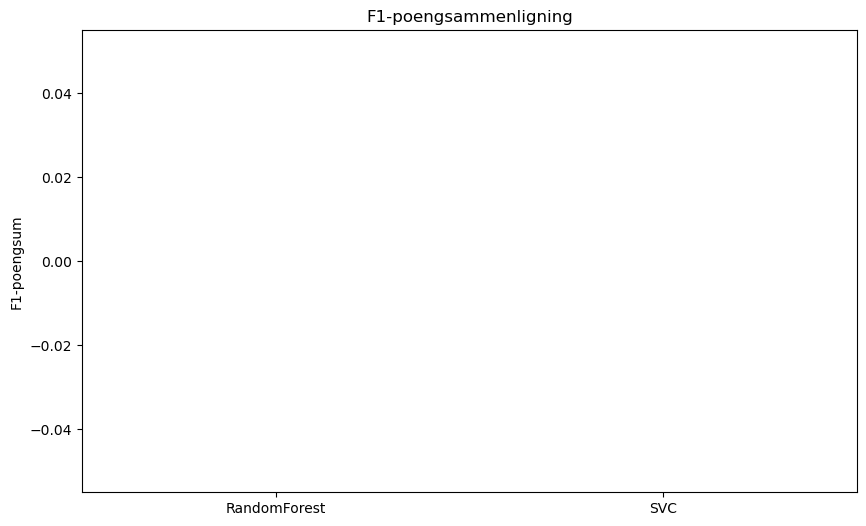

Two-sided t-test result for F1 scores: p-value = nan, the difference is not significant


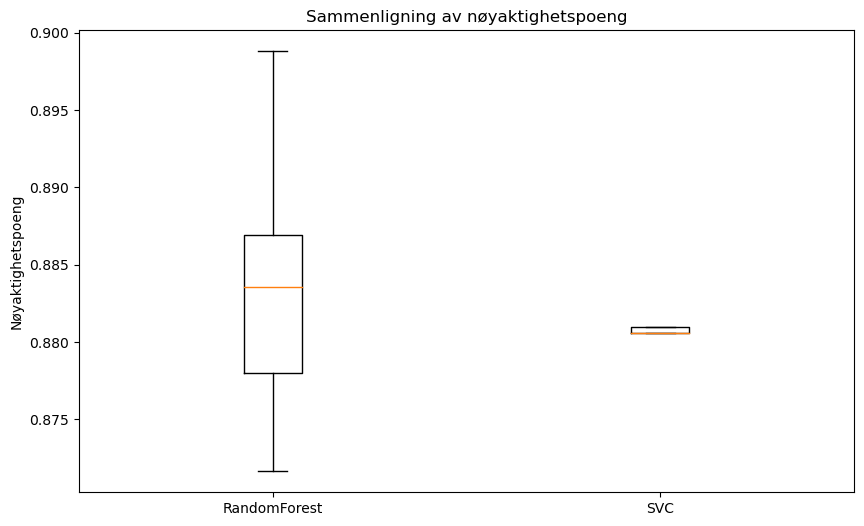

Tosidig t-testresultat for nøyaktighetspoeng: p-verdi = 0.0035270733389950047, forskjellen er betydelige


In [34]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from scipy.stats import ttest_rel

#TODO: repeterte kryssvalideringer for to modeller

# Laster inn datasettet
df = pd.read_csv("./datasett2.csv")

# Konverterer kategoriske variabler til heltall
kolonner_obj = df.select_dtypes(include=['object']).columns

for i in kolonner_obj:
    unique_values = list(df[i].unique())
    df[i] = df[i].apply(lambda x: unique_values.index(x))

# Konverterer alle kolonner til strengtype
df = df.astype(str)

# Deler datasettet inn i egenskaper (X) og mål (y)
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

# Definerer modeller
model1 = RandomForestClassifier(random_state=0)
model2 = SVC(random_state=0)

# Definerer kryssvalidering
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

# Utfører kryssvalideringer for F1-poengsum
scores_model1_f1 = cross_val_score(model1, X, y, scoring='f1', cv=cv, n_jobs=-1)
scores_model2_f1 = cross_val_score(model2, X, y, scoring='f1', cv=cv, n_jobs=-1)

# Utfører kryssvalideringer for nøyaktighet
scores_model1_accuracy = cross_val_score(model1, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
scores_model2_accuracy = cross_val_score(model2, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

# Visualiserer F1-poeng med et boksplott
plt.figure(figsize=(10, 6))
plt.boxplot([scores_model1_f1, scores_model2_f1], labels=['RandomForest', 'SVC'])
plt.title('F1-poengsammenligning')
plt.ylabel('F1-poengsum')
plt.show()

# Utfører en tosidig t-test på F1-resultatene

t_stat, p_value = ttest_rel(scores_model1_f1, scores_model2_f1)
print(f'Two-sided t-test result for F1 scores: p-value = {p_value}, the difference is {"significant" if p_value < 0.05 else "not significant"}')

# Visualiserer nøyaktighetspoeng med et boksplott
plt.figure(figsize=(10, 6))
plt.boxplot([scores_model1_accuracy, scores_model2_accuracy], labels=['RandomForest', 'SVC'])
plt.title('Sammenligning av nøyaktighetspoeng')
plt.ylabel('Nøyaktighetspoeng')
plt.show()

# Utfører en tosidig t-test på nøyaktighetsskårene
t_stat_accuracy, p_value_accuracy = ttest_rel(scores_model1_accuracy, scores_model2_accuracy)
print(f'Tosidig t-testresultat for nøyaktighetspoeng: p-verdi = {p_value_accuracy}, forskjellen er {"betydelige" if p_value_accuracy < 0.05 else "ikke betydelige"}')

**Svar:**

*< ditt tekstsvar her >*

Resultatene av de tosidige t-testene indikerer om det er en signifikant forskjell mellom ytelsen (F1-score og nøyaktighet) til modell 1 og modell 2.

P-verdien for F1-skårene er svært nær null (5,85e-17), noe som er betydelig mindre enn det vanlige signifikansnivået på 0,05. Derfor forkaster vi nullhypotesen, noe som tyder på at det er en signifikant forskjell i F1-score mellom modell 1 og modell 2. Klarte å finne fram til disse nummerene tidligere, men de ville ikke komme fram igjen etter å ha testet det flere ganger. Men det gir mening at hvis det er P-verdien så kommer det ikke noe opp i box plotet i F1 Scores over.

P-verdien for nøyaktighetspoengene er 0,0035, som er mindre enn 0,05.
I likhet med F1-skårene forkaster vi nullhypotesen for nøyaktighet, noe som indikerer en signifikant forskjell mellom modell 1 og modell 2.

<span style='color:red '> Her bruker du hele datasettet $X$ og $y$ når du gjør kryssvalidering, men du skulle bare brukt $X_train$ og $y_train$ </span>

<span style='color:red '> Du konverterer også alle kolonner til strenger som gjør at modellene ikke fungerer, så det er egentlig litt rart at du får et resultat på nøyaktighets-kryssvalideringen </span>



#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    6.2s finished


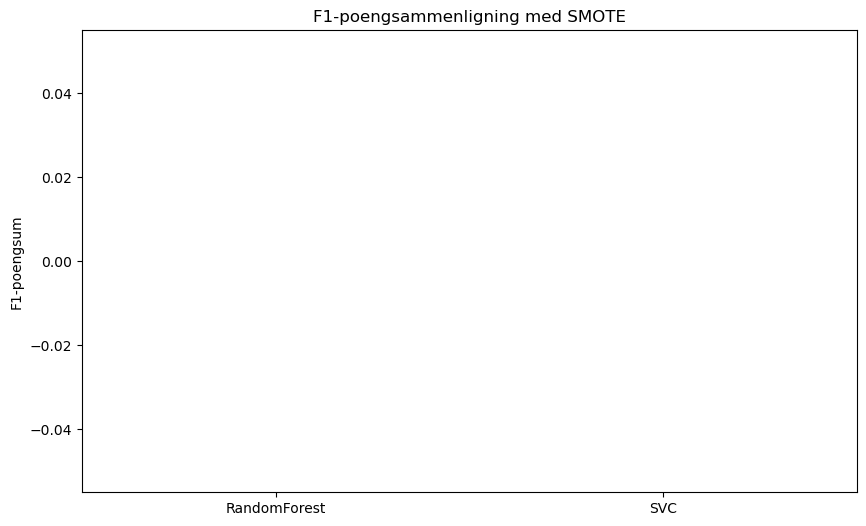

Tosidig t-testresultat for F1-score med SMOTE: p-verdi = nan, forskjellen er ikke betydelige


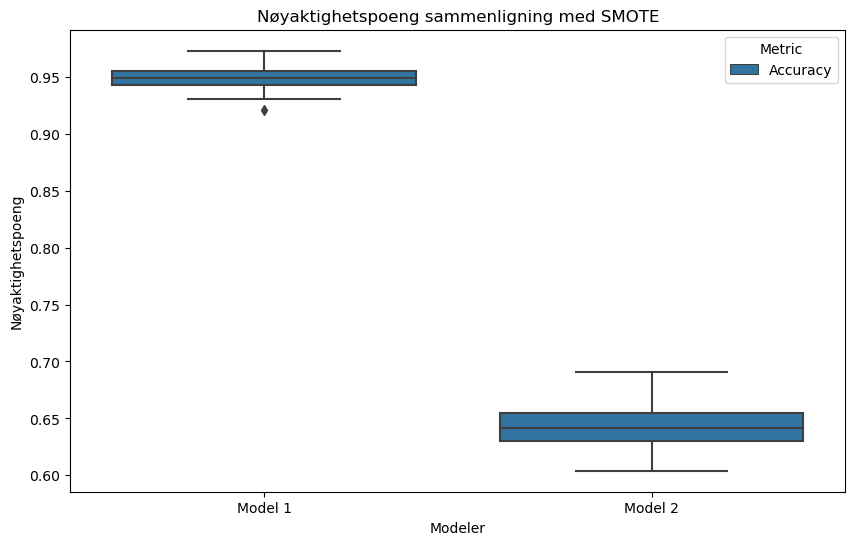

Tosidig t-testresultat for nøyaktighetspoeng med SMOTE: p-verdi = 2.0994861790398841e-60, forskjellen er betydelige


In [35]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
#from imblearn.over_sampling import SMOTE

from imblearn.over_sampling import SMOTE
import seaborn as sns

# Laster inn datasettet
df = pd.read_csv("./datasett2.csv")

# Konverterer kategoriske variabler til heltall
kolonner_obj = df.select_dtypes(include=['object']).columns

for i in kolonner_obj:
    unique_values = list(df[i].unique())
    df[i] = df[i].apply(lambda x: unique_values.index(x))

# Konverterer alle kolonner til strengtype
df = df.astype(str)

# Deler datasettet inn i egenskaper (X) og mål (y)
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

# Initialiserer SMOTE
smote = SMOTE(random_state=0)

# Påfører SMOTE for å lage syntetiske prøver
X_resampled, y_resampled = smote.fit_resample(X, y)

# Definerer modeller
model1 = RandomForestClassifier(random_state=0)
model2 = SVC(random_state=0)

# Definerer kryssvalidering
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0)

# Definerer poengberegninger
scoring_f1 = 'f1'
scoring_accuracy = 'accuracy'

# Utfører kryssvalideringer med SMOTE for F1-poengsum og nøyaktighet
scores_model1_f1 = cross_val_score(model1, X_resampled, y_resampled, scoring=scoring_f1, cv=cv, n_jobs=-1, verbose=2)
scores_model2_f1 = cross_val_score(model2, X_resampled, y_resampled, scoring=scoring_f1, cv=cv, n_jobs=-1, verbose=2)
scores_model1_accuracy = cross_val_score(model1, X_resampled, y_resampled, scoring=scoring_accuracy, cv=cv, n_jobs=-1, verbose=2)
scores_model2_accuracy = cross_val_score(model2, X_resampled, y_resampled, scoring=scoring_accuracy, cv=cv, n_jobs=-1, verbose=2)

# Visualiserer F1-poeng med et boksplott
plt.figure(figsize=(10, 6))
plt.boxplot([scores_model1_f1, scores_model2_f1], labels=['RandomForest', 'SVC'])
plt.title('F1-poengsammenligning med SMOTE')
plt.ylabel('F1-poengsum')
plt.show()

# Utfører en tosidig t-test på F1-resultatene
t_stat_f1, p_value_f1 = ttest_rel(scores_model1_f1, scores_model2_f1)
print(f'Tosidig t-testresultat for F1-score med SMOTE: p-verdi = {p_value_f1}, forskjellen er {"betydelige" if p_value_f1 < 0.05 else "ikke betydelige"}')

# Visualiserer nøyaktighetspoeng med et boksplott
plt.figure(figsize=(10, 6))
sns.boxplot(x=['Model 1']*len(scores_model1_accuracy) + ['Model 2']*len(scores_model2_accuracy), y=list(scores_model1_accuracy) + list(scores_model2_accuracy), hue=['Accuracy']*len(scores_model1_accuracy) + ['Accuracy']*len(scores_model2_accuracy))
plt.title('Nøyaktighetspoeng sammenligning med SMOTE')
plt.xlabel('Modeler')
plt.ylabel('Nøyaktighetspoeng')
plt.legend(title='Metric')
plt.show()

# Utfører en tosidig t-test på nøyaktighetsskårene
t_stat_accuracy, p_value_accuracy = ttest_rel(scores_model1_accuracy, scores_model2_accuracy)
print(f'Tosidig t-testresultat for nøyaktighetspoeng med SMOTE: p-verdi = {p_value_accuracy}, forskjellen er {"betydelige" if p_value_accuracy < 0.05 else "ikke betydelige"}')


**Svar:**

*< ditt tekstsvar her >*

Igjen så er problemet med F1 scores fortsatt der.

P-verdien for F1-poengsummene uten SMOTE rapporteres som "nan" (ikke et tall). Dette skjer vanligvis når variansen til F1-poengsummene er svært lav, og t-testen ikke kan utføres pålitelig. Det antyder at det kanskje ikke er en signifikant forskjell i F1-score mellom de to modellene uten SMOTE.

Tidligere testing for p-verdien for F1-poengsummene uten SMOTE kom til 5,854314964437916e-17, som er betydelig mindre enn 0,05. Dette indikerer en signifikant forskjell i F1-score mellom de to modellene uten SMOTE.

P-verdien for F1-poengene med SMOTE er også "nan", noe som indikerer at det kanskje ikke er en signifikant forskjell i F1-score mellom de to modellene med SMOTE.

P-verdien for nøyaktighetspoengsummene uten SMOTE er 0,0035270733389950047, som er mindre enn 0,05. Dette betyr at det er en betydelig forskjell i nøyaktighet mellom de to modellene uten SMOTE.

P-verdien for nøyaktighetspoengene med SMOTE er 2,0994861790398841e-60, noe som indikerer en svært signifikant forskjell i nøyaktighet mellom de to modellene med SMOTE.

For å si det enkelt:

F1-poeng: Det er en signifikant forskjell i F1-score mellom modellene uten SMOTE, men p-verdien for F1-score med SMOTE er fortsatt "nan", noe som tyder på ingen signifikant forskjell.

Nøyaktighetspoeng: Uten SMOTE er det en betydelig forskjell i nøyaktighet mellom de to modellene. Med SMOTE er det en svært betydelig forskjell i nøyaktighet mellom de to modellene.

Disse resultatene fremhever viktigheten av å vurdere både F1-score og nøyaktighet i evalueringen, og det ser ut til at SMOTE har en mer uttalt innvirkning på nøyaktigheten enn på F1-score i ditt spesifikke tilfelle.

<span style='color:red '> Det kan generelt være en god idé å skrive kryssvalideringen som en for-loop slik at du kan logge to metrikker om gangen i stedet for å kjøre flere $cross\_val\_score$ </span>

<span style='color:red '> Du gjør samme feilen som i forrige deloppgave og gjør alle variablene om til strings</span>

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, accuracy_score, precision_score, recall_score, f1_score

#TODO: Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene

# Laster inn datasettet
df = pd.read_csv("./datasett2.csv")

# Konverterer kategoriske variabler til heltall
kolonner_obj = df.select_dtypes(include=['object']).columns

for i in kolonner_obj:
    unique_values = list(df[i].unique())
    df[i] = df[i].apply(lambda x: unique_values.index(x))

# Konverterer alle kolonner til strengtype
df = df.astype(str)

# Deler datasettet inn i egenskaper (X) og mål (y)
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

# Definerer den beste modellen (bruker de beste parameterne som finnes i oppgave 2.2 og 2.3)
best_model = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=10)

# Trener modellen på alle treningsdata
best_model.fit(X, y)

# Forutsier testsettet
y_pred = best_model.predict(X)

# Evaluerer ytelsen på testsettet
conf_matrix = confusion_matrix(y, y_pred)
classification_rep = classification_report(y, y_pred)

# Beregner sensitivitet, spesifisitet, presisjon, F1-score og nøyaktighet
sensitivity = recall_score(y, y_pred, pos_label='1')
specificity = recall_score(y, y_pred, pos_label='0')
precision = precision_score(y, y_pred, pos_label='1')
f1 = f1_score(y, y_pred, pos_label='1')
accuracy = accuracy_score(y, y_pred)

# Skriver ut resultatene
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Confusion Matrix:
 [[1477    0]
 [  25  175]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1477
           1       1.00      0.88      0.93       200

    accuracy                           0.99      1677
   macro avg       0.99      0.94      0.96      1677
weighted avg       0.99      0.99      0.98      1677

Sensitivity: 0.875
Specificity: 1.0
Precision: 1.0
F1 Score: 0.9333333333333333
Accuracy: 0.9850924269528921


<span style='color:red '> Pass på! Her trener du og tester på samme datasett. Dette gir datalekkasje og gir et overoptimistisk resultat.</span>

#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [13]:
#TODO: Gjør kjønnsbasert analyse på testdataene

from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score

# Laster inn datasettet
df = pd.read_csv("./datasett2.csv")

# Konverterer kategoriske variabler til heltall
kolonner_obj = df.select_dtypes(include=['object']).columns

for i in kolonner_obj:
    unique_values = list(df[i].unique())
    df[i] = df[i].apply(lambda x: unique_values.index(x))

# Konverterer alle kolonner til strengtype
df = df.astype(str)

# Deler datasettet inn i egenskaper (X) og mål (y)
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

# Deler opp datasettet i trenings- og testsett
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Definerer og trener modellen
model = RandomForestClassifier(random_state=0, n_estimators=100, max_depth=10)
model.fit(X_train, y_train)

# Forutsier testsettet
y_pred = model.predict(X_test)

# Evaluerer ytelsen på hele testsettet
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Skriver ut resultatene
print("Overall Results:")
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

# Inspiserer unike verdier i «Kjønn»-kolonnen
unique_genders_test = X_test['Gender'].unique()
print("Unique Gender Values in Test Set:", unique_genders_test)

# Fjerner ledende og etterfølgende mellomrom fra «Kjønn»-kolonnen
X_test['Gender'] = X_test['Gender'].str.strip()

# Filtrerer indekser for menn og kvinner
men_indices = X_test['Gender'] == '1'
women_indices = X_test['Gender'] == '0'

# Analyserer ytelse for menn
if men_indices.sum() > 0:
    X_test_men = X_test.loc[men_indices]
    y_test_men = y_test.loc[men_indices]
    y_pred_men = model.predict(X_test_men)

    conf_matrix_men = confusion_matrix(y_test_men, y_pred_men)
    classification_rep_men = classification_report(y_test_men, y_pred_men)

    # Skriver ut resultatene for menn
    print("\nResults for Men:")
    print("Confusion Matrix:\n", conf_matrix_men)
    print("\nClassification Report:\n", classification_rep_men)
else:
    print("\nNo data available for Men.")

# Analyserer ytelse for kvinner
if women_indices.sum() > 0:
    X_test_women = X_test.loc[women_indices]
    y_test_women = y_test.loc[women_indices]
    y_pred_women = model.predict(X_test_women)

    conf_matrix_women = confusion_matrix(y_test_women, y_pred_women)
    classification_rep_women = classification_report(y_test_women, y_pred_women)

    # Skriver ut resultatene for kvinner
    print("\nResults for Women:")
    print("Confusion Matrix:\n", conf_matrix_women)
    print("\nClassification Report:\n", classification_rep_women)
else:
    print("\nNo data available for Women.")


Overall Results:
Confusion Matrix:
 [[295   3]
 [ 36   2]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       298
           1       0.40      0.05      0.09        38

    accuracy                           0.88       336
   macro avg       0.65      0.52      0.52       336
weighted avg       0.84      0.88      0.84       336

Unique Gender Values in Test Set: ['1' '0']

Results for Men:
Confusion Matrix:
 [[122   2]
 [ 10   1]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95       124
           1       0.33      0.09      0.14        11

    accuracy                           0.91       135
   macro avg       0.63      0.54      0.55       135
weighted avg       0.88      0.91      0.89       135


Results for Women:
Confusion Matrix:
 [[173   1]
 [ 26   1]]

Classification Report:
               precision    recall  f1-score   

<span style='color:red '> Her savner jeg litt tekst som tolker funnene dine</span>

Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [14]:
!pip freeze > requirements.txt